# ** Описание **

In [1]:
from __future__ import division
import scipy
import binascii
from sklearn.metrics import f1_score
import numpy as np
import base64
from sklearn.linear_model import LogisticRegression
import csv
from nltk.tokenize import RegexpTokenizer
import gzip
import pymorphy2
import zlib
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import importlib
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import xgboost
import zipfile
import gzip
import string
import pickle
import re
import sys
from io import BytesIO
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from collections import namedtuple
from scipy import sparse
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
from bs4 import BeautifulSoup
from string import punctuation
from bs4.element import Comment
import matplotlib.pyplot as plt
from multiprocessing.pool import ThreadPool
nltk.download('punkt')
from nltk.tokenize import word_tokenize

C:\Users\vkrin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vkrin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier  
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier

In [3]:
TRACE_NUM = 100
import logging
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [4]:
def to_utf8(text):
    if isinstance(text,  str): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text,  str): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [5]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2lower
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

In [6]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]'] or isinstance(element, Comment):
        return False
    else:
        return True

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    
    links = []
    links_t=''
    for link in soup.findAll('a', attrs={'href': re.compile("^http://")}):
        links.append(link.get('href'))
        links_t+=(' '+link.get_text())
    
    return ' '.join(visible_texts), links, links_t

def tokenize_me(file_text):
    tokens = nltk.word_tokenize(file_text)
    tokens = [morph.parse(i.lower())[0].normal_form for i in tokens if ( i not in string.punctuation )]
 
    stop_words = stopwords.words('russian')+stopwords.words('english')
    stop_words.extend(map(lambda x: x, 
                          ['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на']))
    tokens = [i for i in tokens if ( i not in stop_words )]     
    return ' '.join(tokens)

In [7]:
tnz = RegexpTokenizer('\w+|[^\w\s]+')
morph = pymorphy2.MorphAnalyzer()
def norm(text):
    restxt=''
    text=text.lower()
    for token in tnz.tokenize(text):
        if (token not in stopwords.words('Russian')) and (token != '©') and (token.isdigit() == False) \
        and isnotpunct(token) and (len(token)>1) and (token != '…') and \
        (token != '»') and (token != '«') and (token != '—') and hasnotdigits(token):
            token = morph.parse(token)[0].normal_form
            restxt=restxt+" "+token   
    return restxt 
def isnotpunct(strk):
    for s in strk:
        if s in punctuation:
            return False
    return True  

def hasnotdigits(token):
    for s in token:
        if s in '0123456789':
            return False
    return True

#### Извлечение текста при помощи дополнительных библиотек

In [8]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_title(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    s=soup.find_all('title')
    if s:
        return tokenize_me(s[0].get_text())
    return ''

def html2text_ss(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    links=[]
    texts=''
    for link in soup.find_all('a', href=True):
        links.append(link['href'])
        for text in link.get_text().split():
            texts=texts+' '+text
    return ' '.join(links),' '.join(tokenize_me(texts))

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return ' '.join(tokenize_me(soup.get_text()))

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [9]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [10]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [11]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [12]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print ('threshold %s',  threshold)
            print ('\tclass_prec %s, class_recall %s, class_F1 %s',  r[0])
            print ('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s',  r[1])
            print ('\t\tMacroF1Mesure %s',  ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [13]:
def calc_features(url, html_data,title=False):
    text, links, ankors = text_from_html(html_data)
    text=tokenize_me(text)
    ankors=tokenize_me(ankors)
    all_text=tokenize_me(text) + ' '.join(links)+' '+tokenize_me(ankors)
    words = text.split()
    words_num = len(words)
    ankors_num=len(ankors.split())
    urls_num=len(links)
    if words_num>0:
        uniq=len(set(words))/words_num
    else:
        uniq=0
    len_url=1/len(url)
    compression_level = len(gzip.compress(html_data))/len(html_data)
    return [len(words), compression_level, all_text, uniq, urls_num,len_url, ankors_num, ankors]

In [14]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url'])#, 'features'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name,encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.decode('utf8').strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            #features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url)#, np.array(features))            
                
        trace(i, 1)        

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [20]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_docs =list(load_csv(TRAIN_DATA_FILE, calc_features))

00:52:03 INFO:Complete items 00000
00:52:03 INFO:Complete items 00100
00:52:04 INFO:Complete items 00200
00:52:04 INFO:Complete items 00300
00:52:04 INFO:Complete items 00400
00:52:04 INFO:Complete items 00500
00:52:04 INFO:Complete items 00600
00:52:04 INFO:Complete items 00700
00:52:04 INFO:Complete items 00800
00:52:04 INFO:Complete items 00900
00:52:04 INFO:Complete items 01000
00:52:04 INFO:Complete items 01100
00:52:04 INFO:Complete items 01200
00:52:04 INFO:Complete items 01300
00:52:05 INFO:Complete items 01400
00:52:05 INFO:Complete items 01500
00:52:05 INFO:Complete items 01600
00:52:05 INFO:Complete items 01700
00:52:05 INFO:Complete items 01800
00:52:05 INFO:Complete items 01900
00:52:05 INFO:Complete items 02000
00:52:05 INFO:Complete items 02100
00:52:05 INFO:Complete items 02200
00:52:05 INFO:Complete items 02300
00:52:05 INFO:Complete items 02400
00:52:05 INFO:Complete items 02500
00:52:05 INFO:Complete items 02600
00:52:05 INFO:Complete items 02700
00:52:06 INFO:Comple

Wall time: 6.03 s


In [4]:
X_train_=scipy.sparse.load_npz('train.npz')
X_test_=scipy.sparse.load_npz('test.npz')

In [170]:
train_docs=np.load('train_docs.npy',allow_pickle=True).tolist()

In [16]:
import bz2
from shutil import copyfileobj

In [15]:
def generator(train_docss):
    for doc in train_docss:
        yield doc[3][2]

In [17]:
vectorizer = TfidfVectorizer(max_df=1.0, min_df=0.001, use_idf=True, ngram_range=(1,3))

In [108]:
vectorizer.fit(generator(train_docss=train_docs+test_docs))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=0.001, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,
                vocabulary={'00', '000', '01', '01 2010', '01 2011', '02',
                            '02 2010', '02 2011', '03', '03 2010', '03 2011',
                            '04', '04 08', '04 11', '04 2010', '04 2011', '05',
                            '05 2010', '06', '06 2010', '07', '07 04',
                            '07 2010', '08', '08 04', '08 04 2011', '08 2010',
                            '09', '09 2010', '10', ...})

In [18]:
X_train=vectorizer.fit_transform(generator(train_docss=train_docs))

In [21]:
N=3000
voc=set()
idx = np.ravel(X_train.sum(axis=0).argsort(axis=1))[::-1][:N]
top_words = np.array(vectorizer.get_feature_names())[idx].tolist()
for word in top_words:
    voc.add(word)
print(voc)

{'этаж', 'солт', '13', 'двадцать', 'израиль', 'рёрєр', 'как', 'утилит', 'метро', 'приложение', 'e5', 'приходиться', '81', 'настоящий', 'http', 'uslugi', 'умереть', 'старик', 'туда', 'тёмный', 'ночью', 'prv', '72', 'согласно', 'open', 'база', 'безопасность', 'сколько', 'камаз', 'итог', 'ширина', 'e8', 'факс', 'омск', 'ноябрь', 'детский', 'сњс', 'красноярск', 'key', 'анекдот', 'вернуться', 'легко', 'выполнить', 'быстрый', 'октябрь', 'реализация', 'боев', 'кредитный', 'появляться', 'рёсџ', 'ха', 'tds', 'западный', 'представитель', 'мтс', 'бабушка', 'сотрудничество', 'ростов', 'склад', 'препарат', 'шоу', 'этап', 'витамин', 'порно', 'сеть', 'металл', 'tiu', 'category', 'разрешение', 'авто', 'процесс', 'актёр', '22', 'on', 'активный', 'отдельный', 'упражнение', 'обратный', 'позволить', 'врач', 'рєс', 'кремлёвский', 'знак', '09', '2005', '58', 'самостоятельно', 'build', 'краснодар', 'корень', 'почувствовать', 'leave', 'модель', 'удалить', '77', 'сђс', 'приехать', 'восстановление', 'igrat', 'с

In [19]:
f1=[]
for doc in train_docs:
    f1.append(np.array([np.float64(doc[3][0]),np.float64(doc[3][1]),np.float64(doc[3][3]),np.float64(doc[3][4]),np.float64(doc[3][5]),np.float64(doc[3][6])]))
f1=np.array(f1)

In [21]:
X_train_.shape

(7044, 142036)

In [68]:
f1[0]

array([2.27600000e+03, 2.18764052e-01, 3.19420035e-01, 1.10000000e+01,
       3.57142857e-02, 2.60000000e+01])

In [20]:
x_vs=sparse.csc_matrix(f1).tocsr()
#x_cos_train=sparse.csc_matrix(coss).tocsr()
X_train_=sparse.hstack([X_train, x_vs]).tocsr()

In [24]:
X_train_.shape

(7044, 47516)

In [25]:
y_train=[]
for doc in train_docs:
    y_train.append(float(doc[1]))
y_train=np.array(y_train)

In [23]:
np.save('y_train.npy', y_train)

In [115]:
x1, x2, y1, y2=train_test_split(X_train_, y_train,  test_size=0.1, random_state=42)

In [34]:
from sklearn.utils.testing import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
VotingClassifier
_BinaryGaussianProcessClassifierLaplace
_ConstantPredictor


In [33]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
clf2 = MultinomialNB()
clf3 = SGDClassifier(alpha=0.0001, average=False,
                     class_weight=None,
                     early_stopping=False, epsilon=0.1,
                     eta0=0.0, fit_intercept=True,
                     l1_ratio=0.15,
                     learning_rate='optimal',
                     max_iter=1000,loss='log',
                     n_iter_no_change=5, n_jobs=None,
                     penalty='l2', power_t=0.5,
                     random_state=None, shuffle=True,
                     tol=0.001, validation_fraction=0.1)
clf4= xgboost.XGBClassifier(max_depth=6,learning_rate=0.3,n_estimators=1000,scale_pos_weight=1.5, n_jobs=6,probability=True)
clf6=SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto', kernel='rbf',
                                  max_iter=-1,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False, probability=True)
clf7=RandomForestClassifier(n_jobs=6,n_estimators=1000,max_depth=6,class_weight='balanced')
clf8=KNeighborsClassifier(n_neighbors=12)
clf9=DecisionTreeClassifier(class_weight='balanced')
neuronov_v_sloe=[]
for j in range(10):
    neuronov_v_sloe.append(100)
clf10=MLPClassifier(hidden_layer_sizes=neuronov_v_sloe)
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('NB', clf2), ('sgd', clf3),
                       ('xgb', clf4), ('svc', clf6), ('rf', clf7),
            ('knn', clf8), ('dt', clf9), ('perceptron', clf10)], voting='soft',weights=[1, 1, 1, 2, 1.3, 2, 1,1.3,1.5], n_jobs=6)

In [34]:
import joblib
from distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:50745,Cluster Workers: 3 Cores: 6 Memory: 17.11 GB


In [35]:
with joblib.parallel_backend("dask"):
    eclf1.fit(X_train_, y_train)

y_pred=eclf1.predict(X_test_)

In [26]:
X_train_.shape

(7044, 142036)

In [25]:
scipy.sparse.save_npz('train.npz', X_train_)
scipy.sparse.save_npz('test.npz', X_test_)

In [94]:
depths=[3,4,5,6]
spws=[1,1.3,1.5]
n_ests=[50]#,300,500,700]
for depth in depths:
    for spw in spws:
        for n_est in n_ests:
            model = xgboost.XGBClassifier(max_depth=depth,learning_rate=0.3,n_estimators=n_est,scale_pos_weight=spw, n_jobs=6)
            model.fit(x1,y1)
            print(f1_score(y2, model.predict(x2)),depth,spw, n_est)

0.8967193195625759 3 1 50
0.8952380952380953 3 1.3 50
0.891764705882353 3 1.5 50


KeyboardInterrupt: 

In [31]:
from sklearn.neural_network import MLPClassifier

In [127]:
neuronov_v_sloe=[]
neuronov=[10,100,300,500,1000]
for i in neuronov:
    for j in range(i):
        neuronov_v_sloe.append(100)
    model=MLPClassifier(hidden_layer_sizes=neuronov_v_sloe).fit(x1,y1)
    prediction_1=model.predict(x1)
    prediction_2=model.predict(x2)
    print("x1 ", f1_score(prediction_1,y1))
    print("x2 ", f1_score(prediction_2,y2))
    print("количество слоев ", model.n_layers_)
    neuronov_v_sloe.clear()

C:\Users\vkrin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


x1  0.9869031377899045
x2  0.9612015018773468
количество слоев  12


KeyboardInterrupt: 

In [75]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
test_docs = list(load_csv(TEST_DATA_FILE, calc_features))

01:04:30 INFO:Complete items 00000
01:05:58 INFO:Complete items 00100
01:07:13 INFO:Complete items 00200
01:08:07 INFO:Complete items 00300
01:09:53 INFO:Complete items 00400
01:10:50 INFO:Complete items 00500
01:12:00 INFO:Complete items 00600
01:12:50 INFO:Complete items 00700
01:13:53 INFO:Complete items 00800
01:15:54 INFO:Complete items 00900
01:17:49 INFO:Complete items 01000
01:20:18 INFO:Complete items 01100
01:21:21 INFO:Complete items 01200
01:22:09 INFO:Complete items 01300
01:23:15 INFO:Complete items 01400
01:23:59 INFO:Complete items 01500
01:24:50 INFO:Complete items 01600
01:25:43 INFO:Complete items 01700
01:26:25 INFO:Complete items 01800
01:27:17 INFO:Complete items 01900
01:28:30 INFO:Complete items 02000
01:30:01 INFO:Complete items 02100
01:31:30 INFO:Complete items 02200
01:32:56 INFO:Complete items 02300
01:33:44 INFO:Complete items 02400
01:34:50 INFO:Complete items 02500
01:35:52 INFO:Complete items 02600
01:36:57 INFO:Complete items 02700
01:37:36 INFO:Comple

In [101]:
len(train_docs+test_docs)

23083

In [22]:
X_test=vectorizer.transform(generator(train_docss=test_docs))

In [110]:
y_test=[]
for doc in test_docs:
    y_test.append(doc[1])
y_test=np.array(y_test)
print(y_test)

[ True  True  True ...  True  True  True]


In [24]:
print(X_train_.shape,X_test_.shape)

(7044, 142036) (16039, 142036)


In [23]:
f2=[]
for doc in test_docs:
    f2.append(np.array([np.float64(doc[3][0]),np.float64(doc[3][1]),np.float64(doc[3][3]),np.float64(doc[3][4]),np.float64(doc[3][5]),np.float64(doc[3][6])]))
f2=np.array(f2)
x_vs=sparse.csc_matrix(f2).tocsr()
#x_cos_test=sparse.csc_matrix(coss_test).tocsr()
X_test_=sparse.hstack([X_test, x_vs]).tocsr()

In [85]:
model = xgboost.XGBClassifier(max_depth=6,learning_rate=0.3,n_estimators=1000,scale_pos_weight=1.5, n_jobs=6)

In [146]:
full_data=sparse.vstack([X_train_, X_test_]).tocsr()

In [152]:
from sklearn.semi_supervised import LabelSpreading,LabelPropagation

In [114]:
neuronov_v_sloe=[]
for j in range(10):
        neuronov_v_sloe.append(100)
model=MLPClassifier(hidden_layer_sizes=neuronov_v_sloe).fit(X_train_,y_train)
y_test=model.predict(X_test_)

0.976456009913259

In [87]:
model.fit(X_train_,y_train)
y_pred=model.predict(X_test_)

0.6835474206919194

C:\Users\vkrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
C:\Users\vkrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x000002EDE18DAAC8>>
Traceback (most recent call last):
  File "C:\Users\vkrin\Anaconda3\lib\site-packages\xgboost\core.py", line 956, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


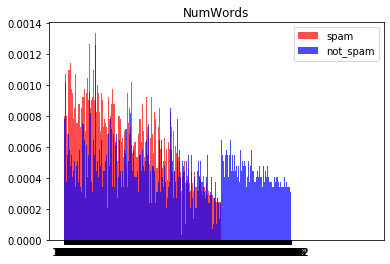

In [67]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

In [ ]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

In [ ]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

In [ ]:
#Добавить графики для остальных фичей

** Классификатор: **
Нужно реализовать

In [ ]:
class Classifier:
    
    def __init__(self):
        pass

    def predict(self, doc):        
        return doc.features[0]                     
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):                
        for doc_num, doc in enumerate(docs):                            
            #TODO вставить код обучения
            trace(doc_num)
        trace(doc_num, 1)

In [ ]:
classifier = Classifier()
classifier.train(train_docs)

In [ ]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

** Рисуем графики **

In [ ]:
plot_results(train_docs, min_threshold=0, max_threshold=3000, step=100, trace=1)

In [87]:
TEST_DATA_FILE  = 'kaggle/kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

#test_docs = load_csv(TEST_DATA_FILE, calc_features)

#threshold = 800

with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item,y in zip(classifier.predict_all(test_docs),y_test):
        writer.writerow([item[0], y])

TypeError: a bytes-like object is required, not 'str'

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
(150, 4) [ 0  0  0  0 -1 -1 -1  0  0  0 -1  0  0 -1 -1 -1  0  0  0 -1  0 -1 -1  0
  0  0 -1  0  0 -1  0 -1 -1  0  0  0  0 -1  0  0 -1  0 -1  0 -1  0  0  0
  0 -1  1  1  1  1  1  1 -1 -1 -1  1  1 -1  1  1 -1  1 -1  1 -1  1  1 -1
 -1  1  1  1  1 -1  1 -1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1 -1 -1 -1  2  2  2  2 -1  2  2 -1 -1 -1 -1  2  2  2  2  2 -1  2  2
  2  2  2 -1 -1  2  2  2 -1  2  2 -1 -1  2  2  2  2  2  2  2  2 -1  2  2
 -1 -1  2  2 -1 -1] [False False False False  True  True  True False False False  True False
 False  True  True  True False False False  True False  True  True False
 False False  True False False  True False  True  True False False False
 False  

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [135]:
file = open("my_submission.csv", "wb")
file.write( bytes(str("Id,Prediction\n"), "utf-8"))
for i in range(len(test_docs)):
    file.write(bytes(str(test_docs[i][0]) + "," +str(int(y_pred[i])) + str("\n"), "utf-8"))
file.close()

In [164]:
#np.save('train_docs.npy', np.array(train_docs, implace=True))
np.save('test_docs.npy', test_docs)

MemoryError: 

In [172]:
import csv
with open('test_docs', "w", newline="") as file:
    writer = csv.writer(file)
    file.cl

In [171]:
pickle.dump(train_docs, open('train.p', 'wb'))
pickle.dump(test_docs, open('test.p', 'wb'))

In [16]:
input_train = open('train.p', 'rb')
input_test = open('test.p', 'rb')
train_docs=pickle.load(input_train)
test_docs=pickle.load(input_test)
input_test.close()
input_train.close()

In [21]:
max_epochs = 10
alpha = 0.025

model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)

In [22]:
tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i,doc in enumerate(generator(train_docss=train_docs+test_docs))]

In [23]:
model.build_vocab(tagged_data)

In [24]:
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

iteration 0


C:\Users\vkrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [52]:
test_data=test_docs[10][3][2]
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

V1_infer [ -1.02624     -9.412314   -15.912084     6.599049     4.1291685
  -9.896153     2.264849    -5.840065    -7.396797     3.791914
  -4.566124     2.3207166   -4.907215     1.9643959    3.4458458
   2.1727035    0.03726032  11.27989    -10.212159    -4.746123
  14.658656    -0.17648442   2.917683     2.5123615    6.1782126
  -8.106794    -2.5798273    6.32896     -5.7203345   -0.546161
  11.339916   -10.809691    11.899398    -2.969841     3.7725005
  -1.1467489    5.6229506   -6.3758616    5.0033298   -2.5071573
   6.8345933    1.2167974   -1.9114177    1.093597    -8.572602
  -6.1242285    9.578417    -6.235271    -3.9235585   -0.24970564
   6.349547     1.6324854  -10.67436      4.009813     9.015545
   3.646399    -5.690334   -11.976712    -1.5372528   -2.7370815
   5.014127    -2.9239216    3.8877947    1.283477    -5.373032
   2.551737    13.521847    -6.4487524    7.5171375   -1.6247194
   6.7707753    6.1042285    2.2689226   -7.456477    10.813289
   7.2756944    8.5267

In [25]:
coss=[]
cos=[]
for i in range(len(train_docs)):
    cos.clear()
    for j in range(len(train_docs)):
        similar_doc = model.docvecs.distance(i,j)
        cos.append(similar_doc)
    coss.append(cos)
    sys.stdout.write('\r {0}...'.format(i))
coss=np.matrix(coss)

 7043...

In [26]:
coss_test=[]
cos_test=[]
for i in range(len(train_docs),len(test_docs+train_docs)):
    cos_test.clear()
    for j in range(len(train_docs)):
        similar_doc = model.docvecs.distance(i,j)
        cos_test.append(similar_doc)
    coss_test.append(cos)
    sys.stdout.write('\r {0}...'.format(i))
coss_test=np.matrix(coss_test)

 23082...

In [27]:
coss_test.shape

(16039, 7044)

In [67]:
len(test_docs)

16039

In [39]:
np.save('coss_train.npy', coss)
np.save('coss_test.npy', coss_test)